In [14]:
import pandas as pd
import numpy as np
import talib as ta

import seaborn as sns
import matplotlib.pyplot as plt


PATH_READ = 'result_ET_1min_Binary.csv'


df = pd.read_csv(PATH_READ, index_col= 'Timestamp')

# df = df[['Target_Class_Avg_1min', 'prediction_label']]

print(df.columns)

Index(['tta_BOP', 'tta_STOCHRSI_timeperiod_6_fastk_period_5_fastd_period_8_0',
       'tta_STOCHRSI_timeperiod_6_fastk_period_5_fastd_period_8_1',
       'tta_TRANGE', 'tta_CDLBELTHOLD', 'tta_CDLCLOSINGMARUBOZU',
       'tta_ULTOSC_timeperiod1_20_timeperiod2_5_timeperiod3_34',
       'tta_MINUS_DM_timeperiod_6', 'tta_ADOSC_fastperiod_14_slowperiod_9',
       'tta_DX_timeperiod_26', 'tta_HT_PHASOR_0', 'tta_HT_PHASOR_1',
       'tta_MFI_timeperiod_36',
       'tta_SAREXT_accelerationlong_28_accelerationshort_26',
       'tta_CDLENGULFING', 'tta_T3_timeperiod_38', 'tta_HT_TRENDMODE',
       'tta_HT_DCPERIOD', 'tta_CDLSHORTLINE', 'tta_HT_DCPHASE',
       'tta_CDL3WHITESOLDIERS', 'tta_CDLMORNINGDOJISTAR', 'tta_CDLTRISTAR',
       'tta_CDLHIKKAKE', 'tta_CDLLONGLEGGEDDOJI', 'tta_HT_SINE_0',
       'tta_HT_SINE_1', 'tta_CDLUNIQUE3RIVER', 'tta_CDL3LINESTRIKE',
       'tta_CDLSTICKSANDWICH', 'tta_CDL3OUTSIDE', 'tta_CDLSPINNINGTOP',
       'tta_CDLLADDERBOTTOM', 'tta_CDLEVENINGDOJISTAR', 'tta_CDL

In [15]:
min_value = df['prediction_label'].min()
max_value = df['prediction_label'].max()

print('Predict min: ' + str(min_value))
print('Predict max: ' + str(max_value))

Predict min: -0.0048295994180625
Predict max: 0.0168004775216104


In [16]:
def quantiles(df, num_interval):
    df_sorted = df.sort_values(by='prediction_label')
   
    quantile_markers = pd.qcut(df_sorted['prediction_label'], q=num_interval, labels=False)

# Add the quantile markers as a new column to the DataFrame
    df_sorted['Interval_Marker'] = quantile_markers

    return df_sorted

In [17]:
df_sorted = quantiles(df, 20)
print(df_sorted)


                      tta_BOP  \
Timestamp                       
2023-07-19 09:34:00 -0.936777   
2023-07-18 09:31:00 -1.000000   
2023-07-19 10:02:00 -0.930978   
2023-07-14 09:32:00 -1.000000   
2023-07-19 09:57:00 -0.767420   
...                       ...   
2023-07-17 15:00:00  0.000000   
2023-07-19 10:49:00  0.055556   
2023-07-17 10:55:00  0.117647   
2023-07-10 09:26:00  0.000000   
2023-07-12 09:26:00  0.000000   

                     tta_STOCHRSI_timeperiod_6_fastk_period_5_fastd_period_8_0  \
Timestamp                                                                        
2023-07-19 09:34:00                                          55.039974           
2023-07-18 09:31:00                                          63.228657           
2023-07-19 10:02:00                                           0.000000           
2023-07-14 09:32:00                                           7.141932           
2023-07-19 09:57:00                                           0.000000        

In [18]:
def quant_analysis_list(df, num_interval, target):
    results = []

    for i in range(num_interval):
        selected_rows = df[df['Interval_Marker'] == i]

        acc = (selected_rows[target] * selected_rows['prediction_label'] > 0).mean() * 100
        p_corr = selected_rows[target].corr(selected_rows['prediction_label'])
        s_corr = selected_rows[target].corr(selected_rows['prediction_label'], method='spearman')
        true_mean = selected_rows[target].mean()
        pred_mean = selected_rows[target].mean()

        results.append([i, acc, p_corr, s_corr, true_mean, pred_mean])

    # Create the summary DataFrame
    columns = ['Interval', 'Percent in the Same Direction', 'Correlation Pearson', 'Correlation Spearman', 'True Mean', 'Predicted Mean']
    summary_df = pd.DataFrame(results, columns=columns)

    summary_df.index = summary_df['Interval']
    summary_df.drop(columns='Interval', inplace=True)

    return summary_df

In [28]:
def see_interval(df, interval, target):
    plt.figure(figsize=(10, 5))

    for index in interval:
        selected_rows = df[df['Interval_Marker'] == index]

        selected_rows = selected_rows.reset_index()
        text = 'Interval ' + str(index)
        sns.lineplot(data=selected_rows[target], label= text, alpha=0.5)

    plt.show()

In [20]:
print(quant_analysis_list(df_sorted, 10, 'Target_Avg_1min'))

          Percent in the Same Direction  Correlation Pearson  \
Interval                                                       
0                             86.111111             0.414851   
1                             82.407407             0.137249   
2                             80.555556             0.059614   
3                             73.148148             0.094160   
4                             80.555556             0.092532   
5                             75.925926            -0.246655   
6                             72.222222             0.086021   
7                             62.962963             0.131153   
8                             57.407407            -0.079844   
9                             58.333333             0.101601   

          Correlation Spearman  True Mean  Predicted Mean  
Interval                                                   
0                     0.204064  -0.001606       -0.001606  
1                     0.139968  -0.000956       -0.

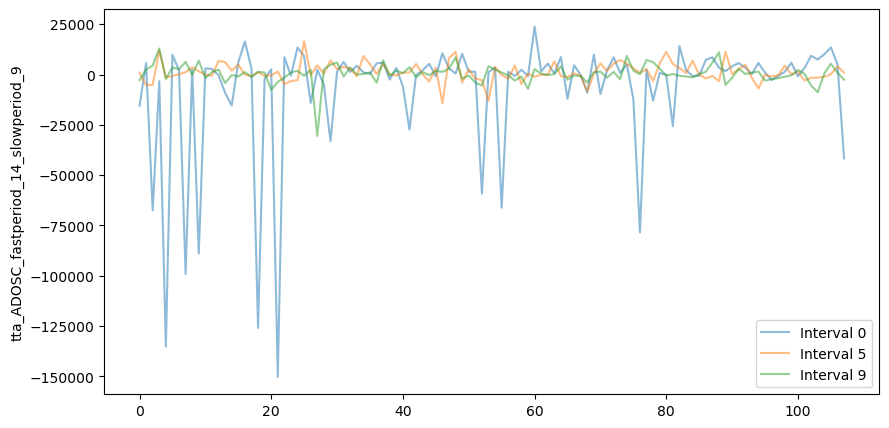

In [33]:
see_interval(df_sorted, [0,5,9], 'tta_ADOSC_fastperiod_14_slowperiod_9')